Name: Holly Kular\
Date: 01-16-2025\
Email: hkular@ucsd.edu\
Description: use CEBRA discovery workflow

In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colormaps
import cebra.models
from cebra import CEBRA

In [53]:
# which model do we want to explore
afc = 6
coh = 'hi'
mod = 0

In [54]:
# load RNN model and trials

if sys.platform.startswith('linux'):
        data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_70_30_{afc}afc/feedforward_only/{coh}_coh"
else:
        data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_70_30_{afc}afc/feedforward_only/{coh}_coh"
        
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat') and not f.startswith('._')]# Get all the trained models (should be 40 .mat files)
model_path = os.path.join(data_dir, mat_files[mod]) 
model = loadmat(model_path)   
data_file = f"{data_dir}/Trials1000_model{model_path[-7:-4]}_neutral.npz"
data = np.load(data_file) #fr1 fr3 outs labs


In [55]:
model.keys()

dict_keys(['__header__', '__version__', '__globals__', 'x1_0', 'r1_0', 'w1_0', 'x2_0', 'r2_0', 'w2_0', 'x3_0', 'r3_0', 'w3_0', 'w21_0', 'w32_0', 'taus_gaus1_0', 'taus_gaus2_0', 'taus_gaus3_0', 'w_in0', 'u', 'o', 'w1', 'w2', 'w3', 'w21', 'w32', 'x1', 'x2', 'x3', 'target', 'w_out', 'r1', 'm1', 'r2', 'm2', 'r3', 'm3', 'w21_m', 'w32_m', 'som_m', 'N1', 'N2', 'N3', 'exc1', 'inh1', 'exc2', 'inh2', 'exc3', 'inh3', 'w_in', 'b_out', 'som_N', 'losses', 'taus', 'eval_perf_mean', 'eval_loss_mean', 'eval_os', 'eval_labels', 'taus_gaus1', 'taus_gaus2', 'taus_gaus3', 'tr', 'activation'])

In [70]:
print(f"w_in = {model['w_in'].shape}\nw_out = {model['w_out'].shape}\nw1={model['w1'].shape}\nw2={model['w2'].shape}\nw3={model['w3'].shape}")


w_in = (200, 6)
w_out = (1, 200)
w1=(200, 200)
w2=(200, 200)
w3=(200, 200)


In [ ]:
data['fr1'].shape

In [4]:
# reshape firing rate data and get trial labels
layer = 1
fr = data[f'fr{layer}'] # shape (1000, 250, 200) trials x time x units
labels = data['labs']  # labels are 1D, shape (1000,)trials

n_trials = fr.shape[0]
n_timepoints = fr.shape[1]
n_units = fr.shape[2]

# collapse across trials and timepoints
fr_col = fr.reshape((n_trials*n_timepoints, n_units))


# Robert's way of making trial labels
sequence = np.arange(int(fr_col.shape[0]/fr.shape[0]))
trial_lab = np.tile(sequence, (fr.shape[0],1)).reshape(fr.shape[0], int(fr_col.shape[0]/fr.shape[0]),1)
trial_lab = trial_lab.reshape((fr.shape[0]*fr.shape[1],1))


# extend trial labels by timepoints
expanded_labels = np.repeat(labels, n_timepoints).reshape((fr_col.shape[0], 1))
#expanded_labels = expanded_labels_fl.astype("int64").reshape((fr_col.shape[0], 1))


# trial structure
trials = np.repeat(range(n_trials), n_timepoints)
trials_fl = trials.astype("float64")

# shuffle for control model
expanded_labels_shuffled = np.random.permutation(expanded_labels)
#expanded_labels_fl_shuffled = np.random.permutation(expanded_labels_fl)
trials_shuffled = np.random.permutation(trials)
trials_fl_shuffled = np.random.permutation(trials_fl)

# combine auxiliary labels
combined_labs = np.hstack((trial_lab, expanded_labels))

In [ ]:
combined_labs.shape

In [ ]:
cebra.models.get_options()

In [5]:
# build CEBRA-Time model
    # uses time without behavior information

cebra_time_model = CEBRA(
    model_architecture = "offset10-model",
    batch_size = 512,
    temperature = 1,
    learning_rate = 3e-4,
    max_iterations = 3000,
    time_offsets = 10,
    distance = "euclidean",
    output_dimension = 3,
    conditional = "time_delta",
    device = "cuda_if_available",
    verbose = True)

# train model
cebra_time_model.fit(fr_col, combined_labs) # leave out trials for now
cebra_time_model.save("cebra_time_model.pt")

pos:  0.2284 neg:  4.9283 total:  5.1567 temperature:  1.0000: 100%|█| 3000/3000


In [6]:
# build CEBRA-Behavior model
    # uses behavior info (trial type)
    
cebra_behavior_model = CEBRA(
    model_architecture = "offset10-model",
    batch_size = 512,
    temperature = 1,
    learning_rate = 3e-4,
    max_iterations = 3000,
    time_offsets = 10,
    distance = "euclidean",
    output_dimension = 3,
    conditional = "time",
    device = "cuda_if_available",
    verbose = True)

# train model
cebra_behavior_model.fit(fr_col, combined_labs) # leave out trials for now
cebra_behavior_model.save("cebra_behavior_model.pt")

pos:  0.1608 neg:  4.8686 total:  5.0294 temperature:  1.0000: 100%|█| 3000/3000


In [7]:
# build CEBRA-Hybrid model
    # uses time and behavior info (trial type)
    
cebra_hybrid_model = CEBRA(
    model_architecture = "offset10-model-mse",
    batch_size = 512,
    temperature = 1,
    learning_rate = 3e-4,
    max_iterations = 3000,
    time_offsets = 10,
    distance = "euclidean",
    output_dimension = 3,
    conditional = "time_delta",
    device = "cuda_if_available",
    verbose = True,
    hybrid = True)

# train model
cebra_hybrid_model.fit(fr_col, combined_labs) # trials not allowed if also float
cebra_hybrid_model.save("cebra_hybrid_model.pt")

behavior_pos:  0.9974 behavior_neg:  3.8340 behavior_total:  4.8314 time_pos:  0


In [8]:
# build CEBRA-control model
    # train on shuffled data
    
cebra_control_model = CEBRA(
    model_architecture = "offset10-model-mse",
    batch_size = 512,
    temperature = 1,
    learning_rate = 3e-4,
    max_iterations = 3000,
    time_offsets = 10,
    distance = "euclidean",
    output_dimension = 3,
    conditional = "time_delta",
    device = "cuda_if_available",
    verbose = True,
    hybrid = True)

# train model
combined_labs_shuffled = np.random.permutation(combined_labs)
cebra_control_model.fit(fr_col, combined_labs_shuffled) # trials_shuffled needs to be float
cebra_control_model.save("cebra_control_model.pt")

behavior_pos:  1.4528 behavior_neg:  4.8310 behavior_total:  6.2838 time_pos:  0


In [9]:
 # Load models and get embeddings

# CEBRA-Time
cebra_time_model = cebra.CEBRA.load("cebra_time_model.pt", backend='auto', weights_only = False)
cebra_time = cebra_time_model.transform(fr_col)

# CEBRA-Behavior
cebra_behavior_model = cebra.CEBRA.load("cebra_behavior_model.pt", backend='auto', weights_only = False)
cebra_behavior = cebra_behavior_model.transform(fr_col)

# CEBRA-Hybrid
cebra_hybrid_model = cebra.CEBRA.load("cebra_hybrid_model.pt", backend='auto', weights_only = False)
cebra_hybrid = cebra_hybrid_model.transform(fr_col)

# CEBRA-Behavior with shuffled labels
cebra_behavior_control_model = cebra.CEBRA.load("cebra_control_model.pt", backend='auto', weights_only = False)
cebra_behavior_control = cebra_behavior_control_model.transform(fr_col)

In [16]:
expanded_labels.shape

(250000, 1)

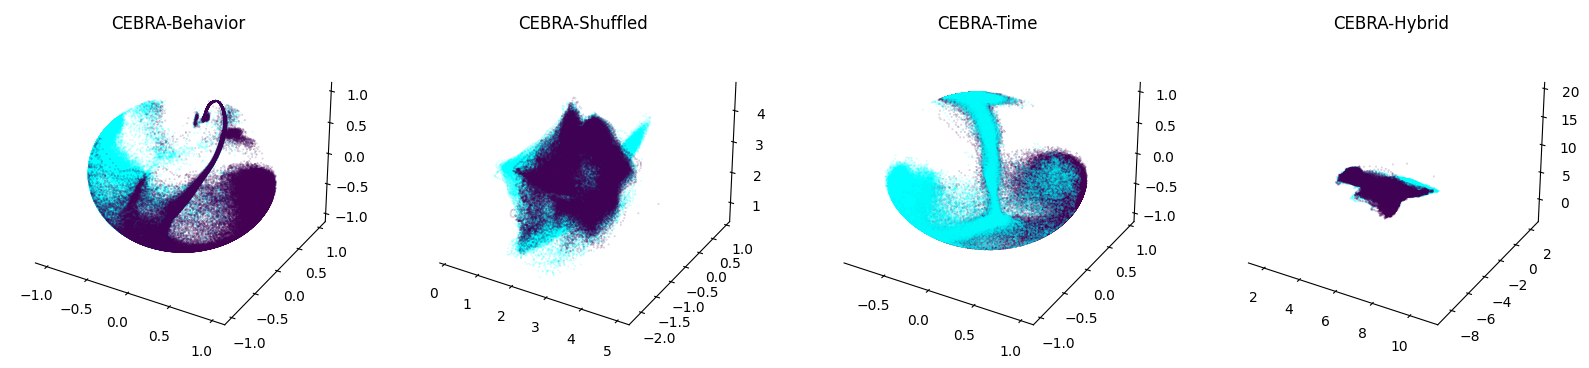

In [17]:
# Visualize embeddings
labs = np.repeat(labels, n_timepoints)
expected = labs == 0
unexpected = labs != 0

fig = plt.figure(figsize=(20,20))

ax1 = plt.subplot(141, projection='3d')
ax2 = plt.subplot(142, projection='3d')
ax3 = plt.subplot(143, projection='3d')
ax4 = plt.subplot(144, projection='3d')

for dir, cmap in zip([expected, unexpected], ["viridis", "cool"]):
    ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_behavior[dir,:], embedding_labels=labs[dir], title='CEBRA-Behavior', cmap=cmap)
    ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_behavior_control[dir,:], embedding_labels=labs[dir], title='CEBRA-Shuffled', cmap=cmap)
    ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_time[dir,:], embedding_labels=labs[dir], title='CEBRA-Time', cmap=cmap)
    ax4=cebra.plot_embedding(ax=ax4, embedding=cebra_hybrid[dir,:], embedding_labels=labs[dir], title='CEBRA-Hybrid', cmap=cmap)
    
fname = f"{afc}afc_{coh}discovery_fr{layer}_mod{mod}.png"
plt.savefig(fname)    
    
plt.show()

In [15]:
dir.shape

(250000, 1)

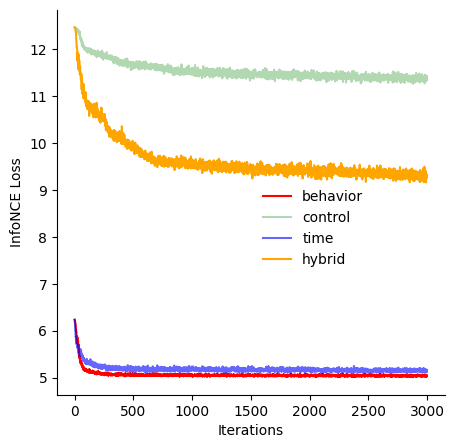

In [20]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.plot(cebra_behavior_model.state_dict_['loss'], c='red', label = 'behavior')
ax.plot(cebra_behavior_control_model.state_dict_['loss'], c='green', alpha = 0.3, label = 'control')
ax.plot(cebra_time_model.state_dict_['loss'], c='blue', alpha=0.6,label = 'time')
ax.plot(cebra_hybrid_model.state_dict_['loss'], c='orange', label = 'hybrid')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('InfoNCE Loss')
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False )
fname = f"{afc}afc_{coh}discovery_fr{layer}_mod{mod}_loss.png"
plt.savefig(fname)   

plt.show()

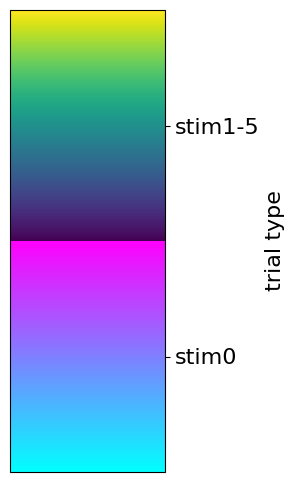

In [19]:
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase
# Create separate colormaps
cool_cmap = plt.cm.cool(np.linspace(0, 1, 256))  # Colormap for "right"
viridis_cmap = plt.cm.viridis(np.linspace(0, 1, 256))  # Colormap for "left"

# Combine the two colormaps
combined_cmap = np.vstack((cool_cmap, viridis_cmap))  # Stack the two colormaps
custom_cmap = ListedColormap(combined_cmap)

# Create a dummy array to represent both sides
dummy_labels = np.linspace(0, 2, 512)  # Range [0, 1] for "right", [1, 2] for "left"

# Plotting
fig, ax = plt.subplots(figsize=(2, 6))  # Adjust size for better vertical view

# Add colorbar
norm = plt.Normalize(0, 2)  # Normalize [0, 1] for "right", [1, 2] for "left"
cb = ColorbarBase(ax, cmap=custom_cmap, norm=norm, orientation='vertical')

# Add labels
cb.set_ticks([0.5, 1.5])
cb.set_ticklabels(['stim0', 'stim1-5'], fontsize = 16)
cb.set_label('trial type', fontsize = 16)

fname = f"{afc}afc_{coh}discovery_fr{layer}_mod{mod}_scale.png"
plt.savefig(fname)    
    
plt.show()
